# Introduction using open source GIS (Python/QGIS) 
* Bulding off what was done in the last workshop
* Attendance of the first workshop isn't a pre-requisite of this one
* But the "output" of the first is the input of the second

# Learning Objectives:

* Import, Parse, and Plot tabular data
* Join Tabular & Spatial Data
* Reproject Coordinate Systems
* Data Normalization w/ Census Data
* Create an Infographic
* Create a heatmap (Maybe, if time allows??)

### GIS w/ Python: Resources:

https://gis.stackexchange.com/

https://geopandas.org/

https://matplotlib.org/


## First, Lets work with geopandas

* Geopandas is a geospatial exentson for pandas

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
# We import the Police Killings file we geocoded in Workshop #1
AllData= pd.read_csv('PoliceKillings.csv',parse_dates=['date'])
# We can then convert teh pandas dataframe into a geopandas "GeodataFrame"
police_Killings = gpd.GeoDataFrame(
    AllData,
    geometry=gpd.points_from_xy(AllData.longitude, AllData.latitude)
)
# We have to assign a coordinate system information associated with these lattitude/longigute coordinate
# epsg:4326 is a code for the WGS 1984 Datum, the coordinate system used by Mapbox's geodocer
police_Killings.crs = {'init' :'epsg:4326'}
police_Killings.head()

,date,id_incident,date.1,day_week,prov,city_town,postal_code,location_type,id_victim,Name,...,taser_deployed,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,summary,latitude,longitude,geocoding_Notes,geometry
0,2012-01-06,1,2012-01-06,Fri,QC,Montreal,H3B 4W5,Urban,0001-V1,*****,...,No,Yes,No,Yes,Yes,Farshad Mohammadi was carrying a knife when he...,45.498173,-73.567157,NaN,POINT (-73.56716 45.49817)
1,2012-01-11,2,2012-01-11,Wed,AB,Onoway,T0E 1V0,Rural,0002-V1,*****,...,No,No,No,Unknown,Yes,RCMP called to an apartment complex in respons...,53.688760,-114.199440,NaN,POINT (-114.19944 53.68876)
2,2012-01-12,3,2012-01-12,Thu,ON,Oakville,L6H 0G6,Urban,0003-V1,*****,...,No,No,No,Unknown,Unknown,Kyle Newman intentionally and repeatedly struc...,43.477098,-79.702193,NaN,POINT (-79.70219 43.47710)
3,2012-02-03,4,2012-02-03,Fri,ON,Toronto,M4C 1X5,Urban,0004-V1,*****,...,No,No,No,Yes,No,"Michael Eligon, who had been involuntarily com...",43.687560,-79.321000,NaN,POINT (-79.32100 43.68756)
4,2012-02-13,5,2012-02-13,Mon,ON,Hamilton,L8K 5J4,Urban,0005-V1,*****,...,No,No,No,Yes,Unknown,"Police had a stolen van under surveillance, an...",43.219570,-79.794930,NaN,POINT (-79.79493 43.21957)


## Now we can import the provincial boundaries.

* They are in "Shapefile" format
* Note the layer has a different CRS
* Canadian Census Data usees the Lambert Conformal Conic Projection
    * This projectoin is ideally suited for displaying the entire country

In [2]:
# Now we can import a shapefile of Canadian Provincial boundaries!
Provinces = gpd.read_file('lpr_000b16a_e.shp')
print(Provinces.crs)

epsg:3347


## Layers need to be in the same coordinate system to match up properly!

* We can re-project the police_Killings layer using the .to_crs function to set the CRS to that of the Provinces
* Then we can make a map!

epsg:3347


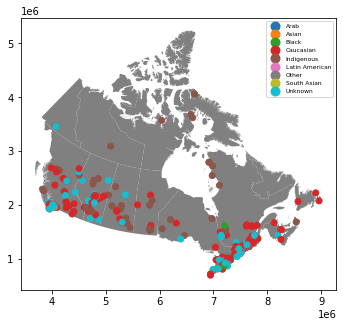

In [3]:
Canada = gpd.read_file('lpr_000b16a_e.shp')
print(Canada.crs)
police_Killings = police_Killings.to_crs(Provinces.crs)

fig,ax=plt.subplots(figsize=(6,5))
Canada.plot(ax=ax,color='grey')
police_Killings.plot(ax=ax,column='race',legend=True,legend_kwds={'loc': 'upper right','fontsize':6})

## Obvioulsly, there are more killings where there are more people.

### But does that tell the whole story?  No!

* Ontariao is the most populous province (14.5 million), and it has the most
* Quebec is the second most populous (8.5 million), yet BC (5 million) has more killings!?

In [5]:
print(police_Killings.groupby('prov').count()['date'].sort_values())

prov
NT      1
YT      2
NL      3
NS      3
NB      4
NU      5
SK     17
MB     19
AB     71
QC     87
BC     98
ON    152
Name: date, dtype: int64


# To really know what's going on, we need to Normalize our data

* Lets import a tabular dataset of provincial level census information
* We have the total population, and the racial breakdown.

In [6]:
Census = pd.read_csv('Census.csv',index_col=[0])
Census.head()

,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Asian,Caucasian
PRUID,,,,,,,,,,,,,,,,
1,35151728,1924635,1577060,1198545,780125,447320,523235,313260,264305,188710,92920,132090,232375,1673780,2952075,25803368
10,519716,2645,2325,2350,1385,635,1375,335,220,75,60,145,255,45725,4180,462186
11,142907,925,2570,825,670,255,585,145,215,210,110,50,85,2735,3705,133527
12,923598,7905,8645,21910,3400,1685,8115,1195,1540,1540,695,635,1390,51490,15475,813453
13,747101,2535,3925,6995,1975,1285,2960,1230,735,1685,230,300,680,29380,9045,693186


## We can join this data set to the provincial shapefile!

* PRUID is a "unique identifier" that represents the provinces.  We can use it as the join key.

In [7]:
Test_Join = Provinces.set_index('PRUID').join(Census)
Test_Join.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,Total,...,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Asian,Caucasian
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# But our join fails!

### Why?  Lets look at the join keys from both files?  Maybe we have a datatype missmatch?

In [8]:
print(Provinces['PRUID'])
print(Census.index)


0     10
1     11
2     12
3     13
4     24
5     35
6     46
7     47
8     48
9     59
10    60
11    61
12    62
Name: PRUID, dtype: object
Int64Index([1, 10, 11, 12, 13, 24, 35, 46, 47, 48, 59, 60, 61, 62], dtype='int64', name='PRUID')


## Sure enough!  The provinces PRUID is an "object", not an integer.

* We can fix that easily and then do the join!
    * Just type 'int64' in .astype() so it matches with the other layer!

In [9]:
Provinces['PRUID'] = Provinces['PRUID'].astype('int64')
Provinces_Join = Provinces.set_index('PRUID').join(Census)
Provinces_Join.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,Total,...,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Asian,Caucasian
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",519716,...,1375,335,220,75,60,145,255,45725,4180,462186
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",142907,...,585,145,215,210,110,50,85,2735,3705,133527
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",923598,...,8115,1195,1540,1540,695,635,1390,51490,15475,813453
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",747101,...,2960,1230,735,1685,230,300,680,29380,9045,693186
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",8164361,...,213740,62825,32405,8055,4575,9840,23040,182890,209870,6949091


## Now we  want to normalize the number of killings by population to get a rate

* We have a few more steps to go through first.
    * The police killings and census data use different abbreviations.  To do a join our dataset with the census data we'll need to assign an new abbreviaton
    * We'll us a dictionary to do this
* Then we can summarize the killings by province and join it to the Provinces_Join layer

## Now we can summarize the killings by province and join it to the Provinces_Join layer
* Note Prince Edward Island doesn't have any.

In [13]:
# Joined = Canada.join(police_Killings)
Provinces_Killings=Provinces_Join.set_index('PREABBR').join(police_Killings.groupby('PREABBR').count()['id_victim'])
Provinces_Killings['id_victim']

PREABBR
N.L.        3.0
P.E.I.      NaN
N.S.        3.0
N.B.        4.0
Que.       87.0
Ont.      152.0
Man.       19.0
Sask.      17.0
Alta.      71.0
B.C.       98.0
Y.T.        2.0
N.W.T.      1.0
Nvt.        5.0
Name: id_victim, dtype: float64

### We can fix this easily using the .fillna() function

### The we can do the normalization!!

* We'll calculat the rate of police killings per ... ten thousand?
    * Divide the number of killings, by the total population.  To get the per person rate
    * Then multiply by 1 million
    * Then sort the values
    
* Then we'll plot it on a map, with a bar graph below for extra context!

In [14]:
Provinces_Killings['Victims'] = Provinces_Killings['id_victim'].fillna(0)
Provinces_Killings['Rate'] = Provinces_Killings['Victims']/Provinces_Killings['Total']*1e4
Provinces_Killings = Provinces_Killings.sort_values(by='Rate')

# Okay, now we're ready to normalize

race
Arab                5
Asian              15
Black              43
Caucasian         212
Indigenous         70
Latin American      3
Other               5
South Asian        10
Unknown            99
Name: date, dtype: int64


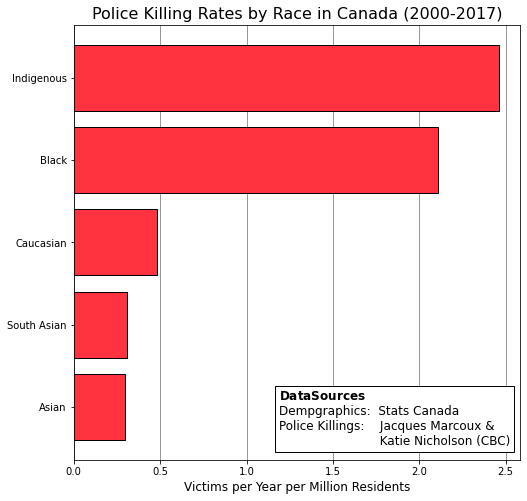

In [17]:
# Provinces_Killings['East Asian']=Provinces_Killings['Asian']
police_Killings.loc[police_Killings['race']=='East Asian','race']='Asian'
Total = police_Killings.groupby('race').count()
# print(policde_killings)
print(Total['date'].T)
Rate = []


# Races = ['Black','Indigenous','Caucasian','East Asian','South Asian']

Races = ['Asian','South Asian','Caucasian','Black','Indigenous']
for race in Races:
    Rate.append((Total['date'].T[race]/Provinces_Killings[race].sum())*1e6/17)
#     print(Total['date'].T[race])#,Provinces_Killings[race])
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
fig,ax=plt.subplots(figsize = (8,8))
ax.barh(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k',color=[1,.2,.25],linewidth = 1)
ax.set_title("Police Killing Rates by Race in Canada (2000-2017)",fontsize = 16)
ax.set_xlabel('Victims per Year per Million Residents',fontsize=12)
ax.grid(axis='x',color='grey')
ax.set_axisbelow(True)
textstr = '$\\bf{Data Sources}$\nDempgraphics:  Stats Canada\nPolice Killings:    Jacques Marcoux &\n'+\
'                          Katie Nicholson (CBC)'
props = dict(facecolor='white')#, alpha=0.75)
ax.text(0.46, 0.16, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.savefig('Rates.png',dpi=400)
# print(Provinces_Killings[['Black','Indigenous','Caucasian','East Asian','South Asian','Arab','West Asian','Mixed']].sum().sort_values()/1e6)

Text(0.5, 0.98, 'Police Killing Rates Across Canada')

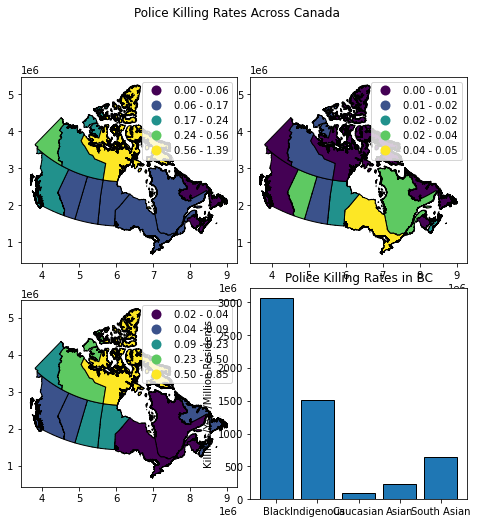

In [19]:

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(6,6)
ax1 = fig.add_subplot(gs[0:3, :3])
ax2 = fig.add_subplot(gs[0:3, 3:])
ax3 = fig.add_subplot(gs[3:, :3])
ax4 = fig.add_subplot(gs[3:, 3:])
Provinces_Killings['Indigenous_pct'] = Provinces_Killings['Indigenous']/Provinces_Killings['Total']
Provinces_Killings['Black_pct'] = Provinces_Killings['Black']/Provinces_Killings['Total']

Provinces_Killings.plot(ax=ax1,column='Rate',edgecolor='k',legend=True,scheme='natural_breaks')
# ax3.bar(Provinces_Killings.index,Provinces_Killings['Rate'])
# ax3.set_xticklabels(Provinces_Killings.index,rotation=30)
Total = police_Killings.groupby('race').count()
Rate = []
Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
for race in Races:
    Rate.append((Total['date'].T[race]/Provinces_Killings[race]).values[0]*1e6/17)
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
ax4.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
ax4.set_title('Police Killing Rates in BC')
ax4.set_ylabel('Killings/Year/Million Residents')
Provinces_Killings.plot(ax=ax3,column='Indigenous_pct',edgecolor='k',legend=True,scheme='natural_breaks')
Provinces_Killings.plot(ax=ax2,column='Black_pct',edgecolor='k',legend=True,scheme='natural_breaks')
plt.suptitle('Police Killing Rates Across Canada')

### Nunavut obviously has a serious problem.  75% of its population is Inuit & its rate is an order of magnitude higher than the other provinces or teritories.

### BC is the worst to of the provinces.  Lets select BC and investigate further.

* For We can select BC using the PREABBR value.
* We'll also re-project into UTM Zone 10 N, this is a more accurate coordinate system for this region

* Then we can look at the racial breakdown of killings in BC using the .groupby function again.
    * We'll create a new dataframe normalizing total killings for different races by total population within those groups
    * Then we can make a barplot highlighting racial biases 


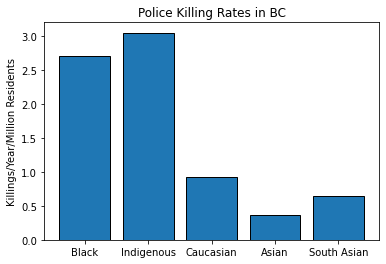

In [20]:
# 26910
BC = Provinces_Killings.loc[Provinces_Killings.index=='B.C.'].to_crs(26910)
BC_Killings = police_Killings.loc[police_Killings['PREABBR']=='B.C.'].to_crs(26910)
Total_BC = BC_Killings.groupby('race').count()

Rate = []
Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
for race in Races:
    Rate.append((Total_BC['date'].T[race]/BC[race]).values[0]*1e6/17)
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
plt.figure()
plt.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
plt.title('Police Killing Rates in BC')
plt.ylabel('Killings/Year/Million Residents')
plt.savefig('BCPoliceKillings.png')
# print(Total_BC['Black']/BC['Black'])

# fig,ax=plt.subplots(figsize=(6,6))

# BC.plot(ax=ax,color='grey',edgecolor='k')
# BC_Killings.plot(ax=ax,column='race',legend=True)
# print(Canada.head())

# from fiona.crs import from_epsg
# from_epsg(2193)
# # Proj({'init': 'epsg:2193', 'no_defs': True}, preserve_flags=True)

## Lets make an infographic for BC, summarizing some of the key points

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(10,10)
ax0 = fig.add_subplot(gs[0:6, 0:6])
BC.plot(ax=ax0,color='grey',edgecolor='k')
BC_Killings.plot(ax=ax0,column='race',legend=True,edgecolor='k')
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
ax0.set_title('Police Killings in BC 2000-2017')


ax1 = fig.add_subplot(gs[1:5, 6:])

Mental_Health = BC_Killings.groupby('mentral_distress_disorder').count()
ax1.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax1.set_title('Was it a Mental Health Crisis?')
# ax1.bar(BC_Year.index,BC_Year.race,width=300,edgecolor='k')
# ax1.set_title('Police Killings by Year in BC')
# ax1.set_ylabel('Number')

ax2 = fig.add_subplot(gs[6:, 0:6])
ax2.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
ax2.set_title('Police Killing Rates by Race in BC')
ax2.set_ylabel('Killings/Year/Million Residents')
ax2.set_xticklabels(Normalized_Rates.index,rotation=30)

BC_Killings.loc[BC_Killings.armed_type=='Knife, axe, other cutting instruments','armed_type']='Knife/Axe'
BC_Killings.loc[BC_Killings.armed_type=='Bat, club, other swinging object','armed_type']='Bat/Club'
BC_Killings.loc[BC_Killings.armed_type=='Air gun, replica gun','armed_type']='Fake Gun'
BC_Killings.loc[BC_Killings.armed_type=='Unknown','armed_type']='None'
Mental_Health = BC_Killings.groupby('armed_type').count()
ax3 = fig.add_subplot(gs[6:, 6:])
ax3.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax3.set_title('Were They Armed?')


plt.tight_layout()
# ax0 = fig.add_subplot(gs[0:6, 0:6])